In [1]:
import os
from tqdm import tnrange, tqdm_notebook, tqdm
import torch
import torchvision
from torch import nn, autograd, optim
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from torchvision.utils import save_image, make_grid
from torch.autograd import grad
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tensorboardX import SummaryWriter

In [2]:
# os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [3]:
from matplotlib import rcParams
rcParams['figure.figsize'] = (12, 8)

%matplotlib inline

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
torch.cuda.is_available()

True

In [6]:
device_ids = [0]

In [7]:
BATCH_SIZE = 128
num_epochs = 100

z_dimension = 100
num_feature = 56 * 56

In [9]:
img_transform = transforms.Compose([
    transforms.ToTensor(),
#     transforms.Normalize((.5, .5, .5), (.5, .5, .5))
#     transforms.Normalize((0.1307,), (0.3081,))
    transforms.Normalize((0.5,), (0.5,))
])

dataset = datasets.MNIST('/home/left/data/mnist', transform=img_transform) #, download=True)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

In [10]:
def normal_init(m, mean, std):
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
        m.weight.data.normal_(mean, std)
        m.bias.data.zero_()

In [11]:
def calc_gradient_penalty(netD, real_data, fake_data):
    alpha = torch.rand(1, 1, 1, 1)
    alpha = alpha.expand_as(real_data)
    alpha = alpha.to(device)
    
    interpolates = alpha * real_data.detach() + ((1 - alpha) * fake_data.detach())

    interpolates = interpolates.to(device)
    interpolates.requires_grad_(True)

    disc_interpolates, _ = netD(interpolates)

    gradients = autograd.grad(outputs=disc_interpolates, inputs=interpolates,
                              grad_outputs=torch.ones(disc_interpolates.size()).to(device),
                              create_graph=True, retain_graph=True, only_inputs=True)[0]

    gradients = gradients.view(gradients.size(0), -1)                              
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean() * 10
    return gradient_penalty

In [12]:
def gen_noise_label(batch_size):
    label = np.random.randint(0, 10, batch_size)
    #prefix = np.zeros((batch_size, 10))
    #prefix[:, label] = 1
    return label # prefix

In [13]:
def gen_noise(batch_size, label):
    prefix = np.zeros((batch_size, 10))
    prefix[np.arange(batch_size), label] = 1
    z = np.random.normal(0, 1, (batch_size, z_dimension))
    prefix = prefix / np.linalg.norm(prefix)
    z[:, :10] + prefix
    return torch.from_numpy(z).float().to(device)

In [14]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.LeakyReLU(.2, True),
            nn.AvgPool2d(2, 2), 
        ) # b 32 14 14
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1),
            nn.LeakyReLU(.2, True),
            nn.AvgPool2d(2, 2),
        ) # b 64 7 7
        
        self.fc1 = nn.Sequential(
            nn.Linear(64 * 7 * 7, 1024),
            nn.LeakyReLU(.2, True),
            nn.Linear(1024, 1),
            nn.Sigmoid(),
        ) # b 1
        self.fc2 = nn.Sequential(
            nn.Linear(64 * 7 * 7, 1024),
            nn.LeakyReLU(.2, True),
            nn.Linear(1024, 10),
            nn.Sigmoid(),
        ) # b 10
    
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)
            
    def forward(self, x): # b 1 28 28
        out = self.conv1(x)
        out = self.conv2(out)
        
        out = out.view(x.size(0), -1)
        img = self.fc1(out)
        con = self.fc2(out)
        return img, con

In [15]:
class Generator(nn.Module):
    def __init__(self, inp_dim, num_feature):
        super(Generator, self).__init__()
        
        self.fc = nn.Sequential(
            nn.Linear(inp_dim, num_feature),
            nn.Sigmoid(),
        ) # b h*w
        self.br = nn.Sequential(
            nn.BatchNorm2d(1),
            nn.LeakyReLU(.2, True),
        ) # b 1 56 56
        
        self.downsample1 = nn.Sequential(
            nn.Conv2d(1, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(.2, True),
        ) # b 64 56 56
        
        self.downsample2 = nn.Sequential(
            nn.Conv2d(64, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(.2, True),
        ) # b 32 56 56
        
        self.downsample3 = nn.Sequential(
            nn.Conv2d(32, 1, 3, padding=1, stride=2),
            nn.Tanh(),
        ) # b 1 28 28
        
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)
            
    def forward(self, x):
        out = self.fc(x)
        
        out = out.view(x.size(0), 1, 56, 56)
        out = self.br(out)
        out = self.downsample1(out)
        out = self.downsample2(out)
        out = self.downsample3(out)
        return out

In [16]:
D = Discriminator().to(device)
G = Generator(z_dimension, num_feature).to(device)

D.weight_init(.0, 0.02)
G.weight_init(.0, 0.02)

D = nn.DataParallel(D, device_ids=device_ids).to(device)
G = nn.DataParallel(G, device_ids=device_ids).to(device)

criterion = nn.CrossEntropyLoss()

d_optimezer = optim.Adam(D.parameters(), lr=2e-4, betas=(0, 0.9))
g_optimezer = optim.Adam(G.parameters(), lr=2e-4, betas=(0, 0.9))

one = torch.FloatTensor([1])
mone = one * -1
one = one.to(device)
mone = mone.to(device)

In [19]:
writer = SummaryWriter('./log/cnn_condition_wgan_gp')

In [20]:
img_path = "save_images/cnn_condition_wgan_img"
if not os.path.exists(img_path): os.makedirs(img_path)

In [21]:
condition_label = np.arange(10)
condition_noise = gen_noise(10, condition_label)

In [22]:
total_count = len(dataloader)
for epoch in tqdm_notebook(range(num_epochs)):
    _step = epoch * total_count
    
    d_loss_total = .0
    g_loss_total = .0
    w_loss_total = .0
    for i, (img, lab) in enumerate(dataloader):
        
        
        ########## D ##########
        for p in D.parameters():
            p.requires_grad_(True)
            
        label = gen_noise_label(img.size(0))
        z = gen_noise(img.size(0), label)
#         with torch.no_grad():
#             zz = z
        fake_img = G(z).detach() ###
        
        real_img = img.cuda()
        real_lab = lab.cuda()
        real_out, real_label = D(real_img)
        real_lab_loss = criterion(real_label, real_lab)
        d_loss_real_lab = real_lab_loss.mean()
        d_loss_real = real_out.mean()
        real_scores = real_out
        
        fake_img = G(z).detach()
        fake_out, fake_label = D(fake_img)
        d_loss_fake = fake_out.mean()
        fake_scores = fake_out
        
        gradient_penalty = calc_gradient_penalty(D, real_img, fake_img)
        
        d_loss = d_loss_fake - d_loss_real + gradient_penalty + 1 * d_loss_real_lab
        
        d_optimezer.zero_grad()
        d_loss.backward()
        d_optimezer.step()
        
        #######################
        w_dist = d_loss_fake - d_loss_real
        
        
        ########## G ##########
        for p in D.parameters():
            p.requires_grad_(False)
        
        label = gen_noise_label(img.size(0))
        z = gen_noise(img.size(0), label)
        fake_img = G(z)
        fake_out, fake_label = D(fake_img)

        gen_label = torch.from_numpy(label).long().to(device)
        gen_label_loss = criterion(fake_label, gen_label).mean()
        gen_cost = -fake_out.mean()
        g_loss = 1 * gen_label_loss + gen_cost

        g_optimezer.zero_grad()
        g_loss.backward()
        g_optimezer.step()
        
        #######################
        
        d_loss_total += d_loss.item() * img.size(0)
        g_loss_total += g_loss.item() * img.size(0)
        w_loss_total += w_dist * img.size(0)
        
        step = _step + i + 1
        
        if (i + 1) % 100 == 0:
            writer.add_scalar('Discriminator Real Loss', d_loss_real.item(), step)
            writer.add_scalar('Discriminator Fake Loss', d_loss_fake.item(), step)
            writer.add_scalar('Discriminator Loss', d_loss.item(), step)
            writer.add_scalar('Generator Loss', g_loss.item(), step)
            writer.add_scalar('Wasserstein Distance', w_dist.item(), step)
        
        
        if (i + 1) % 300 == 0:
            tqdm.write('  Epoch[{}/{}], Step: {:6d}, d_loss: {:.6f}, g_loss: {:.6f} real_scores: {:.6f}, fake_scores: {:.6f}, W: {:.6f}'.format(epoch+1, num_epochs, 
                                          (i+1) * BATCH_SIZE, 
                                          d_loss, g_loss, 
                                          real_scores.mean(), 
                                          fake_scores.mean(), w_dist))
    
    
    setp = (epoch + 1) * total_count
    _d_loss_total = d_loss_total / (total_count * (epoch + 1))
    _g_loss_total = g_loss_total / (total_count * (epoch + 1))
    _w_loss_total = w_loss_total / (total_count * (epoch + 1))
    
    writer.add_scalar('Discriminator Total Loss', _d_loss_total, step)
    writer.add_scalar('Generator Total Loss', _g_loss_total, step)
    
    tqdm.write("Finish Epoch [{}/{}], D Loss: {:.6f}, G Loss: {:.6f}, W: {:.6f}".format(epoch+1, 
                                                                             num_epochs, 
                                                                             _d_loss_total,
                                                                             _g_loss_total,
                                                                             _w_loss_total, ))
    
    writer.add_image('Generator Image', make_grid(fake_img.view(-1, 1, 28, 28).cpu().data, normalize=True, scale_each=True), step)
    condition_img = G(condition_noise)
    writer.add_image('Condition Generator Image', make_grid(condition_img.view(-1, 1, 28, 28).cpu().data, normalize=True, scale_each=True), step)
    
    if epoch == 0:
        real_images = real_img.view(-1, 1, 28, 28).cpu().data
        save_image(real_images, os.path.join(img_path, 'real_images.png'))
    
    
    
    fake_images = fake_img.view(-1, 1, 28, 28).cpu().data
    save_image(fake_images, os.path.join(img_path, 'fake_images-{}.png'.format(epoch+1)))
    save_image(condition_img, os.path.join(img_path, 'condition_images-{}.png'.format(epoch+1)))

  Epoch[1/100], Step:  38400, d_loss: 6.184546, g_loss: 1.602756 real_scores: 0.306313, fake_scores: 0.423273, W: 0.116961
Finish Epoch [1/100], D Loss: 990.231089, G Loss: 232.577498, W: 5.030541
  Epoch[2/100], Step:  38400, d_loss: 3.574717, g_loss: 2.004647 real_scores: 0.657127, fake_scores: 0.832428, W: 0.175301
Finish Epoch [2/100], D Loss: 297.451256, G Loss: 109.013382, W: 10.519745
  Epoch[3/100], Step:  38400, d_loss: 2.628466, g_loss: 1.448479 real_scores: 0.294097, fake_scores: 0.386269, W: 0.092172
Finish Epoch [3/100], D Loss: 135.681141, G Loss: 75.088288, W: 4.941686
  Epoch[4/100], Step:  38400, d_loss: 2.262346, g_loss: 2.284075 real_scores: 0.726820, fake_scores: 0.776798, W: 0.049978
Finish Epoch [4/100], D Loss: 80.027677, G Loss: 56.446899, W: 2.034644
  Epoch[5/100], Step:  38400, d_loss: 1.528742, g_loss: 1.775828 real_scores: 0.526828, fake_scores: 0.533838, W: 0.007010
Finish Epoch [5/100], D Loss: 54.345638, G Loss: 46.002473, W: -0.469384
  Epoch[6/100], St

KeyboardInterrupt: 

In [20]:
writer.close()

In [22]:
torch.save(D.state_dict(), './ser/condition_wgan_gp_discriminator.pt')
torch.save(G.state_dict(), './ser/condition_wgan_gp_generator.pt')

In [ ]:
D.load_state_dict(torch.load('./ser/condition_wgan_gp_discriminator.pt'))
G.load_state_dict(torch.load('./ser/condition_wgan_gp_generator.pt'))

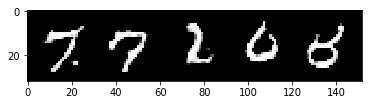

In [25]:
words = np.array([4,5,4,4,0])
z = gen_noise(words.shape[0], words)
images = G(z)
# save_image(images, 'xx.png')
plt.imshow(Image.fromarray(make_grid(images).mul(255).clamp(0, 255).byte().permute(1, 2, 0).cpu().numpy()))
plt.show()